<a href="https://colab.research.google.com/github/dcolinmorgan/AXA_AE_app/blob/main/DC_ts_pollution_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pollution effect on lung health forecasting using graph neural networks and LSTM

**Author:** [Daniel Morgan](https://www.linkedin.com/in/dcolinmorgan/)<br>
**Date created:** 2022/07/28<br>
**Last modified:** 2022/07/28<br>
**Description:** This example demonstrates how to do timeseries forecasting over graphs.

## Setup

In [1]:
import pandas as pd
import numpy as np
import os
# !pip install umap-learn
# !pip install hdbscan
# import umap
# import hdbscan
import networkx as nx

import sklearn.cluster as cluster
import typing
import matplotlib.pyplot as plt
import functools,glob,pickle,os,collections,gzip
from geopy.geocoders import Nominatim
import geopy.distance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# !wget https://github.com/dcolinmorgan/AXA_AE_app/raw/main/axa_p.zip
# !7z x /content/axa_p.zip
# !git clone https://github.com/dcolinmorgan/aqi-stations-scraper.git

df2=pd.read_parquet('/content/AE_AXA_dat_full.parquet')


# list_a = ['pneumonia', 'COPD','asthma','resp','lung','pulm']#,'~Cancer']
# list_b = ['Cancer']
df2.columns=['pat_id','cd9_loc','sess','sex','age','cd9_code','mini_loc','loc1','date','tmp','diag1','diag2','tmp']

# df2=df[df['diag1'].isin(list_a)]
# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

# df.diag1, df.diag2 = np.where(df.diag1.str.contains('None'), [df.diag2, df.diag1], [df.diag1, df.diag2])
# del df['sess'], df['tmp'], df['diag2']
# df=df[~df['diag1'].isna()]

# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

df2.replace({'RH':'Ruttonjee Hospital'},inplace=True)
df2.replace({'PYN':'Pamela Youde Nethersole Eastern Hospital'},inplace=True)
df2.replace({'QEH':'Queen Elizabeth Hospital'},inplace=True)
df2.replace({'CMC':'Caritas Medical Centre'},inplace=True)
df2.replace({'KWH':'Kwong Wah Hospital'},inplace=True)
df2.replace({'TMH':'Tuen Mun Hospital'},inplace=True)
df2.replace({'PWH':'Prince of Wales Hospital'},inplace=True)
df2.replace({'NDH':'North District Hospital'},inplace=True)
df2.replace({'YCH':'Yan Chai Hospital'},inplace=True)
df2.replace({'UCH':'United Christian Hospital'},inplace=True)
df2.replace({'QMH':'Queen Mary Hospital'},inplace=True)
df2.replace({'PWH':'Princess Margaret Hospital'},inplace=True)
df2.replace({'POH':'Pok Oi Hospital'},inplace=True)
df2.replace({'TKO':'Tseung Kwan O Hospital'},inplace=True)
df2.replace({'AHN':'Alice Ho Miu Ling Nethersole Hospital'},inplace=True)
df2.replace({'SJH':'St. John Hospital'},inplace=True)
df2.replace({'NLT':'North Lantau Hospital'},inplace=True)
df2.replace({'TSH':'Tang Shiu Kin Hospital'},inplace=True)
df2.replace({'PMH':'Princess Margaret Hospital'},inplace=True)


#organize
cc=pd.DataFrame()#(columns=['date','pm25','pm10','o3','no2','so2','co','loc'])
files=glob.glob('/content/aqi-stations-scraper/data/japan-aqi/*')
for file in files:
    data=pd.read_csv(file,sep=' |,')
    data['loc1']=os.path.basename(file).split(',')[0]
    cc=cc.append(data)

data2=cc[['date','pm25','pm10','o3','no2','so2','co','loc1']]
data2['loc1']=data2['loc1'].str.upper().replace({'-':' '},regex=True)
data2['date']=pd.to_datetime(data2['date'])

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(df2['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]


data2.replace('CENTRALNAYA STR','central',inplace=True)
data2.replace('NORTH KHAYAM','sheung shui station',inplace=True)
data2.replace('SOUTHERN','southern island',inplace=True)
data2.replace('SOUTHERN PART OF CHENGYANG DISTRICT','chengyang',inplace=True)
### possible to get PM data for Shek O, Blue Pool Rd and A Kung Gnam


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [31]:
data_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data2['loc1'])):
    try:
        a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    except AttributeError:
        print('no location data for: '+str(i))
    data_loc[ii]=[a,b,i]
data_loc=data_loc.transpose()
data_loc.columns=['lat','long','name']
data_loc=data_loc[3:]

data_loc=data_loc[~data_loc.duplicated(['lat','long'],keep='first')]
data_loc.reset_index(inplace=True)
data_loc=data_loc[data_loc['name']!='chengyang']
data_loc=df_loc.append(data_loc)[['lat','long','name']]

data_loc.reset_index(inplace=True)

# ## Cluster and take mean of locations lat and lon ##
from sklearn.cluster import KMeans
# import umap
X=np.array(data_loc[['lat','long']],dtype='float64')
k=18
model = KMeans(n_clusters=k,n_init=20).fit(X)
class_predictions=model.predict(X)
# umap.UMAP(n_neighbors=k)
data_loc['kmeans{k}'] = class_predictions

JJJ=data_loc

no location data for: CENTRAL SCHOOL
no location data for: NORTH CHINA INSTITUTE OF AEROSPACE
no location data for: NORTH WEST UNIVERSITY VAAL CAMPUS
no location data for: NORTHWEST WATER COMPANY


In [32]:


data_loc.lat=data_loc.lat.astype('float')
data_loc.long=data_loc.long.astype('float')
data_loc2=data_loc

# data_loc=data_loc.groupby('kmeans{k}').mean()
data_loc = data_loc.groupby('kmeans{k}').agg({
   'name': lambda x: ','.join(set(x)),
   'lat': 'mean',
   'long': 'mean'
}).reset_index()

# geopy DOES use latlon configuration
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))

d5=data2.merge(data_loc2,left_on='loc1',right_on='name')
d5.rename(columns={'kmeans{k}':'kmeans'},inplace=True)
d5=d5[['date','pm25','pm10','o3','no2','so2','co','loc1','kmeans','lat','long']]

d6=data_loc2.merge(df2,left_on='name',right_on='cd9_loc')
d6=d6[['date','cd9_loc','diag1','age','kmeans{k}']]
d6.rename(columns={'kmeans{k}':'kmeans'},inplace=True)

d5.date=d5.date.astype('str')
d6.date=d6.date.astype('str')

d7=d5.merge(d6,left_on=['date','kmeans'],right_on=['date','kmeans'])#,how='outer')


In [33]:
###ADJACENCY MATRIX --> calculate from aggregated location lat/lon
data_loc=data_loc[data_loc['name'].str.contains(',')]

square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)
distances.shape
# distances.to_numpy()

(13, 13)

In [7]:
# data=pd.read_csv('/content/drive/MyDrive/hku/AXA/axa_ae_lung_all.txt.gz',sep='\t')

### Data visualization



In [8]:
d8=d7[['date','pm25','pm10','o3','no2','so2','co','diag1','age','kmeans']]
d8['diag1'][d8['diag1']!='COPD (496:1)']=0
d8['diag1'][d8['diag1']=='COPD (496:1)']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing im

In [9]:
d8.fillna(0,inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(d8.drop(columns=['date','diag1','kmeans'])), columns=d8.columns.drop(['date','diag1','kmeans']))
df_scaled['diag1']=d8['diag1']
df_scaled['kmeans']=d8['kmeans']
cols=df_scaled.columns
df_scaled[cols] = df_scaled[cols].apply(pd.to_numeric, errors='coerce')
df_scaled['date']=d8['date']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


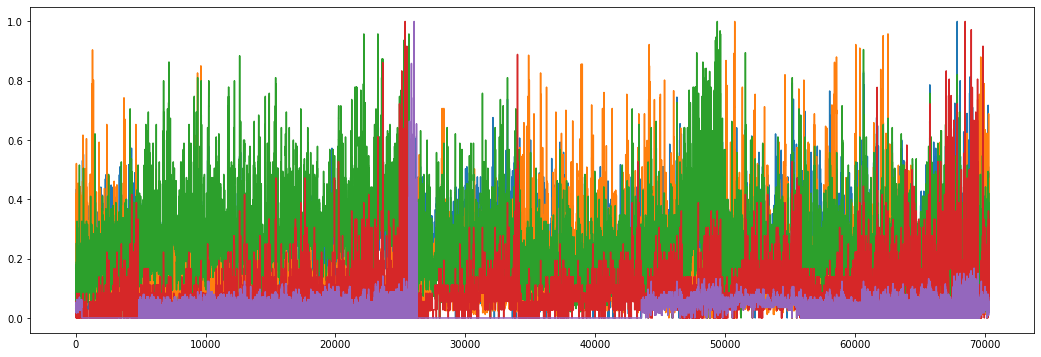

In [42]:
plt.figure(figsize=(18, 6))
plt.plot(df_scaled.iloc[:,1:6])
# plt.plot(speeds_array[:, [0, -1]])
# plt.legend(["route_0", "route_25"])

In [12]:

shaperrr=df_scaled.pivot_table(columns='kmeans',values='age',index='date').fillna(method='ffill').shape
jeff= np.empty(np.append(shaperrr,8))

# dummyarray = np.empty((4,1))
jeff[:] = np.nan

# jeff = pd.DataFrame(jeff)
for j,i in enumerate(df_scaled.columns.drop(['kmeans','date'])):
  scaled=df_scaled.pivot_table(columns='kmeans',values=i,index='date')
  scaled.fillna(method='bfill',inplace=True)#.shape
  scaled.fillna(method='ffill',inplace=True) 
  scaled.dropna(how='any',axis=0,inplace=True)
  # jeff=np.nanmean([jeff,scaled],axis=0)
  jeff[:,:,j]=scaled

jeff[:,:,7:][jeff[:,:,7:]>0]=1
kevin=jeff[:,:,7:]
jeff=jeff[:,:,:7]

We can also visualize the correlation between the timeseries in different routes.

Text(0, 0.5, 'HK_AE cluster')

<Figure size 864x864 with 0 Axes>

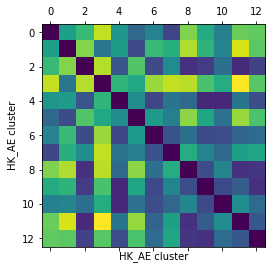

In [13]:
plt.figure(figsize=(12, 12))
plt.matshow((distances.T))
plt.xlabel("HK_AE cluster")
plt.ylabel("HK_AE cluster")

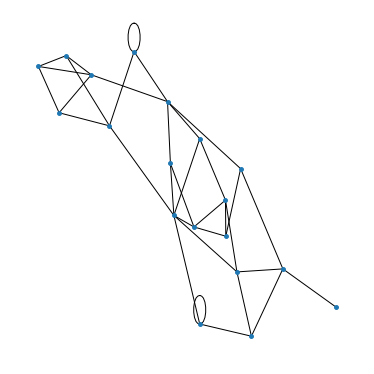

In [34]:
plt.figure(figsize=(5, 5))
# colors = papers["subject"].tolist()
cc=JJJ.reset_index()[['index','kmeans{k}']]
cc.rename(columns={'index':'source','kmeans{k}':'target'},inplace=True)
cc['source']=cc['source'].astype('int')
cc['target']=cc['target'].astype('int')

cora_graph = nx.from_pandas_edgelist(cc)
# subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15)


### Splitting and normalizing data

Next, we split the speed values array into train/validation/test sets,
and normalize the resulting arrays:

In [44]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array_X, val_array_X, test_array_X = preprocess(jeff, train_size, val_size)
print(f"train X size: {train_array_X.shape}")
print(f"validation X size: {val_array_X.shape}")
print(f"test X size: {test_array_X.shape}")

train_array_Y, val_array_Y, test_array_Y = preprocess(kevin, train_size, val_size)
print(f"train X size: {train_array_Y.shape}")
print(f"validation X size: {val_array_Y.shape}")
print(f"test X size: {test_array_Y.shape}")


train X size: (1273, 12, 7)
validation X size: (509, 12, 7)
test X size: (765, 12, 7)
train X size: (1273, 12, 1)
validation X size: (509, 12, 1)
test X size: (765, 12, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [55]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 32
multi_horizon = True


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        # np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        data_array,
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset_X, val_dataset_X, train_dataset_Y, val_dataset_Y = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array_X, val_array_X, train_array_Y, val_array_Y]
)

test_dataset_X, test_dataset_Y = (
    create_tf_dataset(test_array_X,input_sequence_length,forecast_horizon,batch_size=test_array_X.shape[0],shuffle=False,multi_horizon=multi_horizon)
    for test_array in [test_array_X,test_array_Y]
)
    


In [56]:
train_dataset_X

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None))>

##test

In [57]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = ((distances.iloc[:12,:12]<7.5)*1)#compute_adjacency_matrix(distances)#, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 12, number of edges: 30


### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gnn_citations/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages

In [58]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


In [59]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [64]:
in_feat = train_array_X.shape[2]
batch_size = 64
epochs = 20
input_sequence_length = train_array_X.shape[0]
forecast_horizon = 32
multi_horizon = False
out_feat = 1
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset_X,
    validation_data=val_dataset_X,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20


ValueError: ignored

In [62]:
val_dataset_X

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None))>

In [63]:
train_dataset_X

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 12, 7), dtype=tf.float64, name=None))>

In [ ]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")